# Logistic Regression vs LogRegCCD on Synthetic Data

In [14]:
import os
if not os.path.exists("./notebooks"):
    %cd ..
    %cd ..
    %cd ..

import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import pandas as pd
from dataclasses import dataclass
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from src.log_reg_ccd import LogRegCCD
from src.data.data_loader import SyntheticDataLoader
from src.data.dataset_interface import DataInterface
import src.measures as measure

## User specified variables

In [15]:
random_seed = 42
chosen_experiment = 'Default' # Chosen experiment title - check under Experiments params section
run_analyses = True # wheter to run parameters analyses
results_dir = 'results' # If not None - directory to save te analyses plots

## Utils

In [16]:
@dataclass
class ExperimentParams:
    title: str
    n: int
    p: float
    d: int
    g: float
    eps: float = 1e-3
    lam_max: float = 10.0
    lam_count: int = 100
    k_fold: int = 10

In [17]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [18]:
DEFAULT_N = 1000
DEFAULT_P = 0.5
DEFAULT_D = 50
DEFAULT_G = 0

In [19]:
aucroc = measure.AUCROC()
ba = measure.BalancedAccuracy()

## Experiments params

In [20]:
experiments = [
    
    ExperimentParams(title='Default', n=DEFAULT_N, p=DEFAULT_P, d=DEFAULT_D, g=DEFAULT_G),

    ExperimentParams(title='Few samples', n=100, p=DEFAULT_P, d=DEFAULT_D, g=DEFAULT_G),
    ExperimentParams(title='Lots of samples', n=10000, p=DEFAULT_P, d=DEFAULT_D, g=DEFAULT_G),

    ExperimentParams(title='Slightly imbalanced', n=DEFAULT_N, p=0.3, d=DEFAULT_D, g=DEFAULT_G),
    ExperimentParams(title='Highly impalanced', n=DEFAULT_N, p=0.1, d=DEFAULT_D, g=DEFAULT_G),

    ExperimentParams(title='Few features', n=DEFAULT_N, p=DEFAULT_P, d=10, g=DEFAULT_G),
    ExperimentParams(title='Lots of features', n=DEFAULT_N, p=DEFAULT_P, d=500, g=DEFAULT_G),
    ExperimentParams(title='More features than samples', n=DEFAULT_N, p=DEFAULT_P, d=1500, g=DEFAULT_G),

    ExperimentParams(title='Weak correlation', n=DEFAULT_N, p=DEFAULT_P, d=DEFAULT_D, g=0.1),
    ExperimentParams(title='Moderate correlation', n=DEFAULT_N, p=DEFAULT_P, d=DEFAULT_D, g=0.5),
    ExperimentParams(title='Strong correlation', n=DEFAULT_N, p=DEFAULT_P, d=DEFAULT_D, g=0.8),

    ExperimentParams(title='Moderate correlation, lots of features', n=DEFAULT_N, p=DEFAULT_P, d=500, g=0.5),
    ExperimentParams(title='Strong correlation, lots of features', n=DEFAULT_N, p=DEFAULT_P, d=500, g=0.8),
]

experiment = next(exp for exp in experiments if exp.title == chosen_experiment)

## Helpers functions

In [21]:
def test_model(model, X, y, save_path=None, ccd=True, pr=True):
    """ Evaluate model according to chosen metrics"""

    results = {}

    y_pred = model.predict(X)
    if ccd:
        y_pred_proba = model.predict_proba(X)
        results['coefficients'] = model.best_beta
    else:
        y_pred_proba = model.predict_proba(X)[:,1]
        results['coefficients'] = np.concatenate((model.intercept_, model.coef_[0]))

    results['accuracy'] = accuracy_score(y, y_pred)
    results['auc_roc'] = aucroc(y, y_pred_proba)
    results['balanced_accuracy'] = ba(y, y_pred)

    if pr:
        print(f"\nCoefficients: {results['coefficients']}")
        print(f"\n{color.CYAN}{color.UNDERLINE}{aucroc}{color.END}: {results['auc_roc']}")
        print(f"\n{color.CYAN}{color.UNDERLINE}{ba}{color.END}: {results['balanced_accuracy']}")
        print(f"\nAccuracy: {results['accuracy']:.4f}")

    if save_path:
        with open(save_path, 'w') as f:
            f.write("="*50 + "\n")
            f.write("MODEL EVALUATION RESULTS\n")
            f.write("="*50 + "\n\n")
            
            f.write("COEFFICIENTS:\n")
            f.write(str(results['coefficients']) + "\n\n")
            
            if 'auc_roc' in results:
                f.write(f"AUC-ROC SCORE: {results['auc_roc']:.4f}\n\n")
            
            if 'balanced_accuracy' in results:
                f.write(f"BALANCED ACCURACY: {results['balanced_accuracy']:.4f}\n\n")
            
            f.write(f"ACCURACY: {results['accuracy']:.4f}\n\n")
            
            f.write("="*50 + "\n")
        
        plot_path = str(save_path).replace('.txt', '_confusion_matrix.pdf')
        plt.savefig(plot_path, format='pdf', bbox_inches='tight')
    
    plt.show()

    return results

In [22]:
def ex(experiment):
    """Method to run single experiment."""

    di = DataInterface(SyntheticDataLoader(experiment.p, experiment.n, experiment.d, experiment.g, random_seed))
    di.split_data(val_size=0.2, test_size=0.3)
    di.standardize_data()

    data = di.get_data()
    X_train, y_train = data['train_data'], data['train_labels']
    X_valid, y_valid = data['val_data'], data['val_labels']
    X_test, y_test = data['test_data'], data['test_labels']

    model = LogisticRegression(penalty=None)
    model.fit(X_train, y_train)
    results_lr = test_model(model, X_test, y_test, ccd=False, pr=False)

    model_ccd = LogRegCCD(verbose=False)
    model_ccd.fit(X_train, y_train, experiment.eps, experiment.lam_max, experiment.lam_count, experiment.k_fold)
    results_ccd = test_model(model_ccd, X_test, y_test, pr=False)

    model_ccd.validate(X_valid, y_valid, measure=aucroc)
    result_ccd_auc_roc = test_model(model_ccd, X_test, y_test, pr=False)

    model_ccd.validate(X_valid, y_valid, measure=ba)
    results_ccd_ba = test_model(model_ccd, X_test, y_test, pr=False)

    return {
        'results_lr': results_lr,
        'results_ccd': results_ccd,
        'result_ccd_auc_roc': result_ccd_auc_roc,
        'results_ccd_ba': results_ccd_ba
    }


In [23]:
def run_variable_experiments(variable_name, variable_values):
    """Method to run anylysis regarding chosen variable."""

    results = []
    for value in variable_values:
        if variable_name == 'n':
            exp = ExperimentParams(title=f'n_{value}', n=value, p=DEFAULT_P, d=DEFAULT_D, g=DEFAULT_G)
        elif variable_name == 'p':
            exp = ExperimentParams(title=f'p_{value}', n=DEFAULT_N, p=value, d=DEFAULT_D, g=DEFAULT_G)
        elif variable_name == 'd':
            exp = ExperimentParams(title=f'd_{value}', n=DEFAULT_N, p=DEFAULT_P, d=value, g=DEFAULT_G)
        elif variable_name == 'g':
            exp = ExperimentParams(title=f'g_{value}', n=DEFAULT_N, p=DEFAULT_P, d=DEFAULT_D, g=value)
        
        ex_result = ex(exp)
        results.append({
            'variable': variable_name,
            'value': value,
            'results_lr': ex_result['results_lr'],
            'results_ccd': ex_result['results_ccd'],
            'result_ccd_auc_roc': ex_result['result_ccd_auc_roc'],
            'results_ccd_ba': ex_result['results_ccd_ba']
        })
    return results

In [24]:
def plot_results(variable_results, metric='auc_roc'):
    """Method to plot synthetic data parameters influence analysis"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    variables = ['n', 'p', 'd', 'g']
    titles = ['Varying n (samples)', 'Varying p (class balance)', 'Varying d (features)', 'Varying g (correlation)']
    
    for i, var in enumerate(variables):
        ax = axes[i]
        var_data = [r for r in variable_results if r['variable'] == var]
        
        x = [d['value'] for d in var_data]
        y_lr = [d['results_lr'][metric] for d in var_data]
        y_ccd = [d['results_ccd'][metric] for d in var_data]
        y_auc_ccd = [d['result_ccd_auc_roc'][metric] for d in var_data]
        y_ba_ccd = [d['results_ccd_ba'][metric] for d in var_data]

        ax.plot(x, y_lr, label='Logistic Regression', marker='o')
        ax.plot(x, y_ccd, label='CCD', marker='s')
        ax.plot(x, y_auc_ccd, label='AUC ROC CCD', marker='s')
        ax.plot(x, y_ba_ccd, label='BA CCD', marker='s')
        ax.set_title(titles[i])
        ax.set_xlabel(var)
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    return fig

## Synthetic data parameters influence analyses

### Experiments ranges

In [25]:
n_values = np.linspace(100, 10000, num=20, dtype=int) 
p_values = np.linspace(0.1, 0.9, num=20)
d_values = np.linspace(10, 500, num=20, dtype=int)
g_values = np.linspace(0, 0.9, num=20)

### Analyses run

C:\Users\weron\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


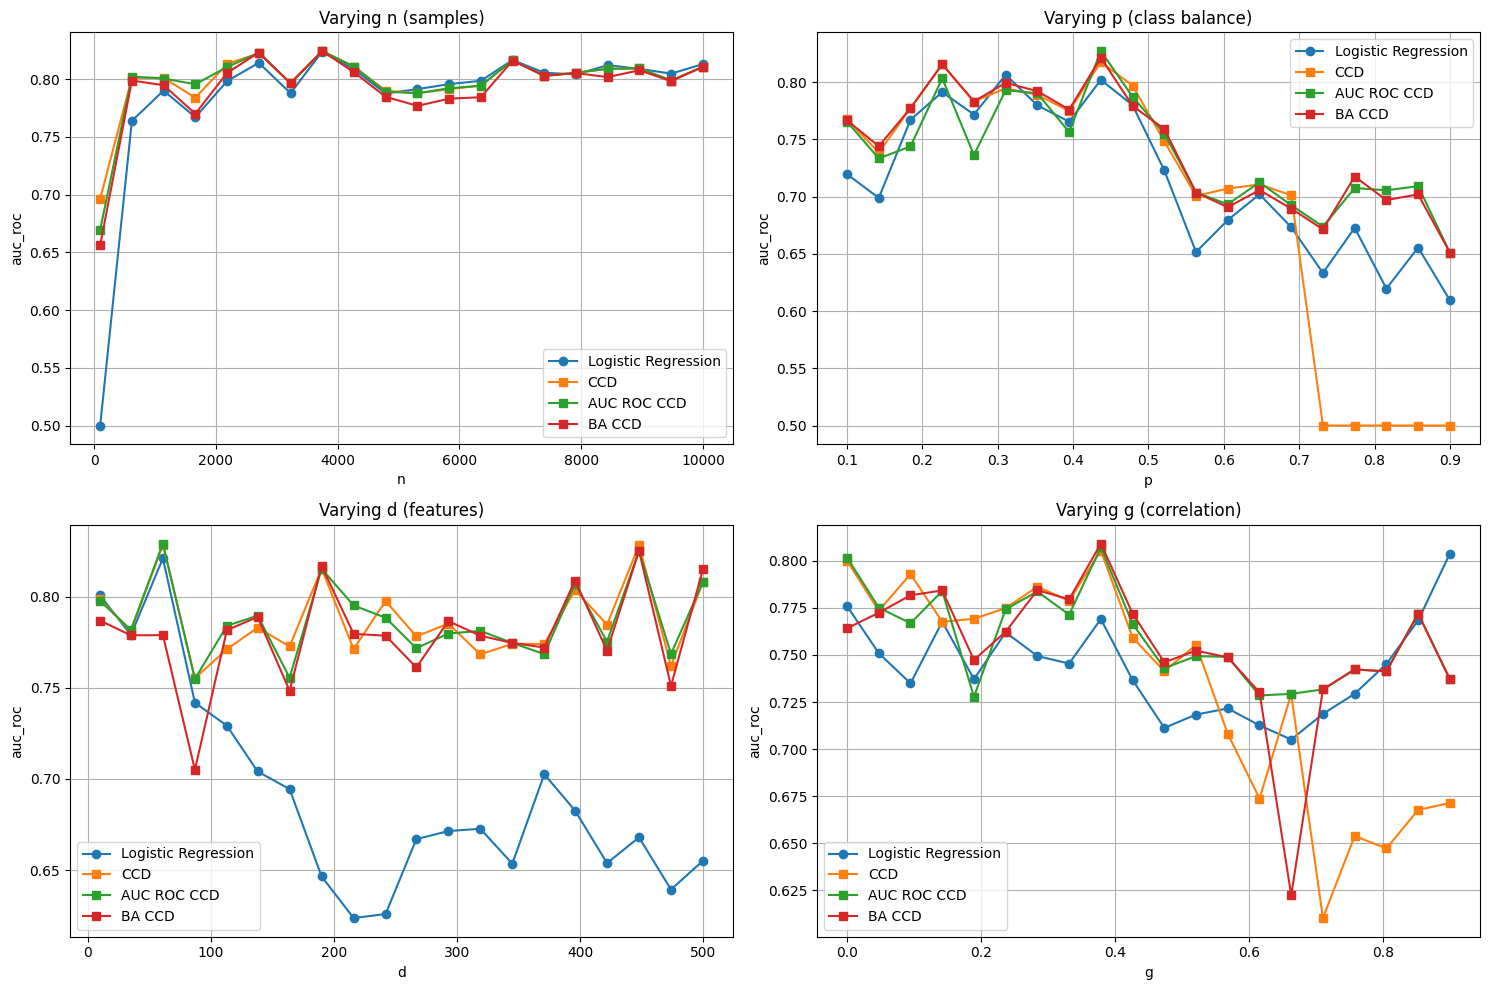

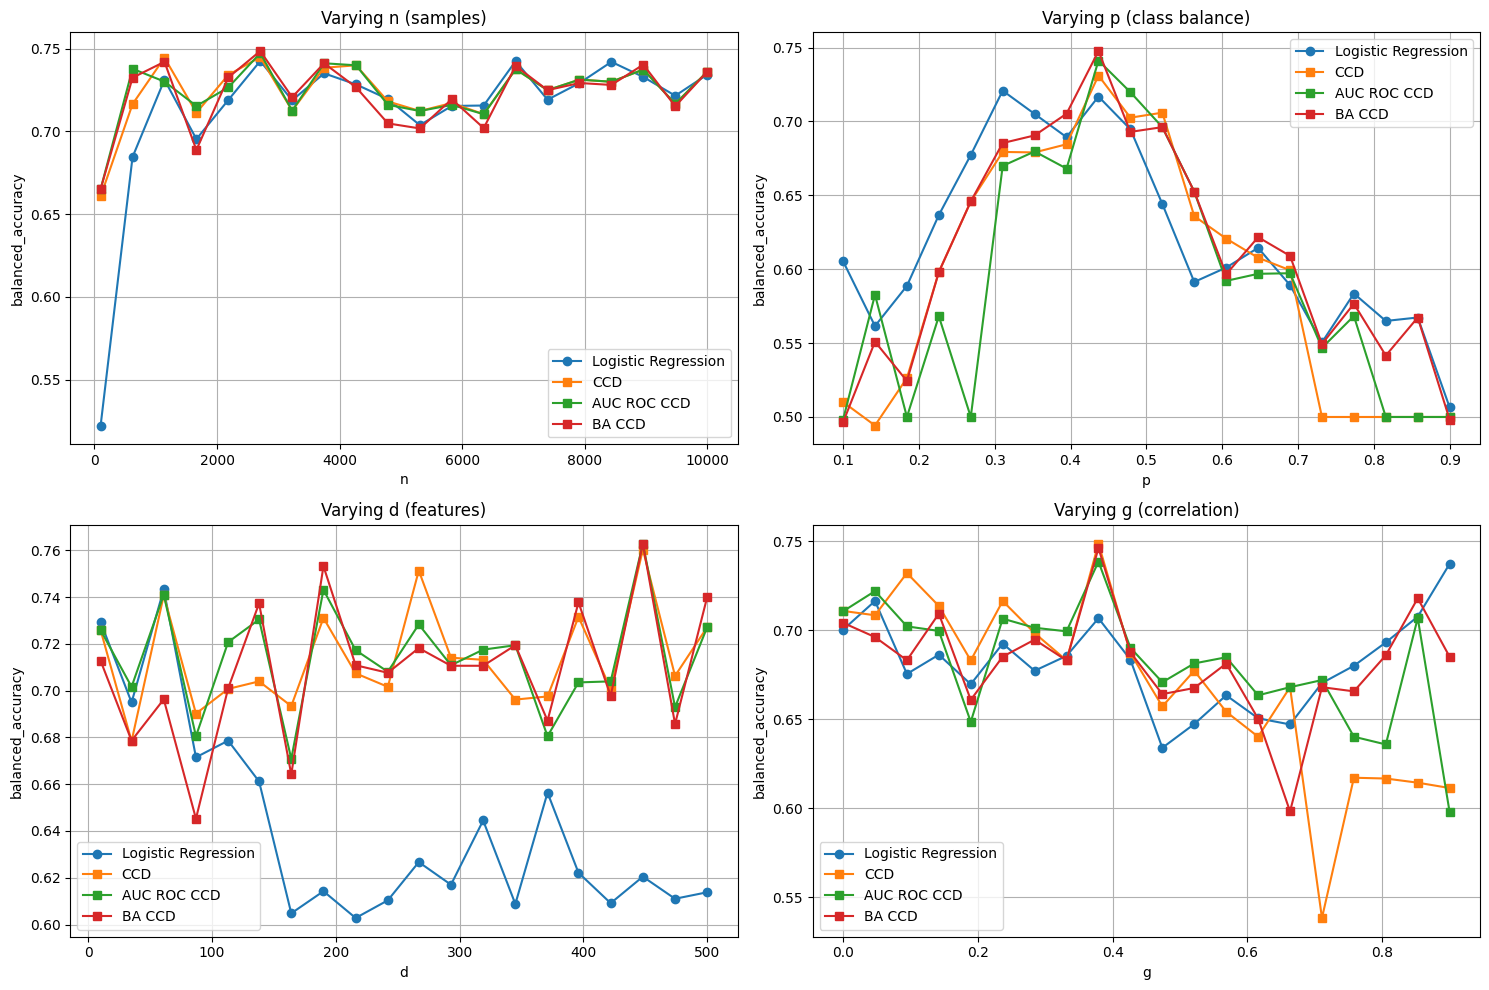

In [26]:
if run_analyses:
    all_results = []
    all_results.extend(run_variable_experiments('n', n_values))
    all_results.extend(run_variable_experiments('p', p_values))
    all_results.extend(run_variable_experiments('d', d_values))
    all_results.extend(run_variable_experiments('g', g_values))

    fig_auc = plot_results(all_results, metric='auc_roc')
    fig_ba = plot_results(all_results, metric='balanced_accuracy')

    if results_dir:
        os.makedirs(results_dir, exist_ok=True)
        fig_auc.savefig(os.path.join(results_dir, 'auc_roc_comparison.png'), bbox_inches='tight')
        fig_ba.savefig(os.path.join(results_dir, 'balanced_accuracy_comparison.png'), bbox_inches='tight')

# Chosen experiment

## Data loading

In [27]:
di = DataInterface(SyntheticDataLoader(experiment.p, experiment.n, experiment.d, experiment.g, random_seed))
di.split_data(val_size=0.2, test_size=0.3)
di.standardize_data()
data = di.get_data()
X_train, y_train = data['train_data'], data['train_labels']
X_valid, y_valid = data['val_data'], data['val_labels']
X_test, y_test = data['test_data'], data['test_labels']

## LogisticRegression

In [28]:
model = LogisticRegression(penalty=None)
model.fit(X_train, y_train)
_ = test_model(model, X_test, y_test, ccd=False, pr=True)


Coefficients: [ 0.00971202  1.03020449  0.42963825  0.53936039  0.38949626  0.15684098
  0.21319342  0.23537587  0.16191342  0.18365853  0.06636172 -0.03334925
  0.1675601   0.14399671  0.16017726  0.05761118  0.11356124 -0.13747389
 -0.1433764  -0.02271276  0.00399469 -0.1159668  -0.02256725 -0.01848604
  0.31799332  0.02435789  0.18783127  0.16353952  0.1279509   0.09794269
  0.04099777  0.09912719  0.1330662   0.1994868   0.15223957  0.03409524
 -0.14943674 -0.14482669 -0.07198809  0.03577617 -0.01984858  0.06421358
 -0.18171279 -0.07524695  0.11412908 -0.06403878  0.00704852 -0.04643063
  0.07066416  0.04998123  0.07003251]

AUC ROC: 0.7759733036707452

Balanced accuracy: 0.7003337041156841

Accuracy: 0.7000


## LogRegCCD

In [29]:
model_ccd = LogRegCCD(verbose=False)
model_ccd.fit(X_train, y_train, experiment.eps, experiment.lam_max, experiment.lam_count, experiment.k_fold)
_ = test_model(model_ccd, X_test, y_test, pr=True)


Coefficients: [ 0.01679999  0.82839425  0.35343592  0.38804144  0.20431537  0.04584613
  0.09847743  0.11018118  0.07652657  0.09700259  0.00593517  0.
  0.06665085  0.03875914  0.05061008  0.          0.         -0.00504982
 -0.03919326  0.         -0.         -0.         -0.         -0.
  0.17557204  0.          0.0863379   0.04484714  0.05237606  0.
  0.          0.0038647   0.02436728  0.06263572  0.          0.
 -0.04475238 -0.00392981 -0.          0.         -0.          0.
 -0.07868828 -0.          0.03586744 -0.          0.         -0.
  0.         -0.          0.        ]

AUC ROC: 0.8000889877641825

Balanced accuracy: 0.7109010011123471

Accuracy: 0.7100


### AUC ROC

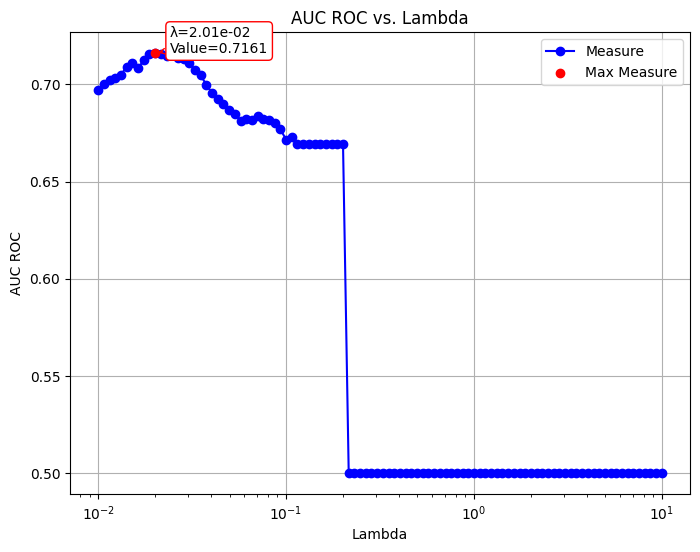


Coefficients: [ 0.0171817   0.80107548  0.33854074  0.36403546  0.17744671  0.02713264
  0.08105123  0.09239367  0.06425006  0.07975552  0.          0.
  0.05127216  0.01841191  0.0325067   0.          0.         -0.
 -0.01965605  0.         -0.         -0.         -0.         -0.
  0.1540951   0.          0.06887984  0.02164482  0.03874691  0.
  0.          0.          0.00377674  0.04192485  0.          0.
 -0.02629738 -0.         -0.          0.         -0.          0.
 -0.05927124 -0.          0.01655653 -0.          0.         -0.
  0.         -0.          0.        ]

AUC ROC: 0.8017352614015573

Balanced accuracy: 0.710678531701891

Accuracy: 0.7100


In [30]:
model_ccd.plot(X_valid, y_valid, measure=aucroc)
_ = model_ccd.validate(X_valid, y_valid, measure=aucroc)
_ = test_model(model_ccd, X_test, y_test, pr=True)

### Balanced Accuracy

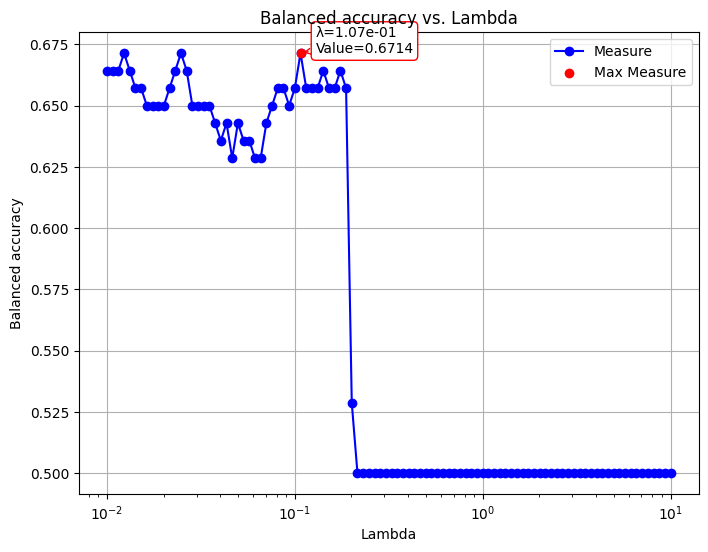


Coefficients: [ 0.01437347  0.39316522  0.02028302  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.
  0.         -0.          0.        ]

AUC ROC: 0.7641824249165741

Balanced accuracy: 0.7042269187986652

Accuracy: 0.7033


In [31]:
model_ccd.plot(X_valid, y_valid, measure=ba)
_ = model_ccd.validate(X_valid, y_valid, measure=ba)
_ = test_model(model_ccd, X_test, y_test, pr=True)